<a href="https://colab.research.google.com/github/iliruslanili/gb_neural_networks/blob/main/gb_neural_network_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Грузим необходимые библиотеки

In [1]:
# The full neural network code!
###############################
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Sun Dec  4 18:31:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Грузим и предобрабатываем датасет

(60000, 784)


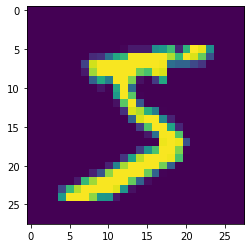

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

plt.imshow(train_images[0])

# Flatten the images.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))
print(train_images.shape)

# Строим модель нейронной сети

In [4]:
# Build the model.
model = Sequential([
  Dense(64, activation='relu', input_shape=(784,)),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax'),
])

# Compile the model.
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

# Обучаем модель

In [5]:
# Train the model.
history_1 = model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=5,
  batch_size=32,
)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3547 - accuracy: 0.8933
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1821 - accuracy: 0.9453
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1371 - accuracy: 0.9574
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1161 - accuracy: 0.9635
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1020 - accuracy: 0.9681


# Проверим модель

In [6]:
# Evaluate the model.
model.evaluate(
  test_images,
  to_categorical(test_labels)
)

313/313 [==============================] - 1s 2ms/step - loss: 0.1236 - accuracy: 0.9627


[0.12359156459569931, 0.9627000093460083]

In [7]:
# Save the model to disk.
model.save_weights('model.h5')

# Load the model from disk later using:
# model.load_weights('model.h5')

In [8]:
# Predict on the first 5 test images.
predictions = model.predict(test_images[:5])

# Print our model's predictions.
print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(test_labels[:5]) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 80ms/step
[7 2 1 0 4]
[7 2 1 0 4]


# Обработаем датасет по своему. Добавим аугментацию и обучим свёрточную модель нейронки

In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [21]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

num_classes = 10

train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

datagen = ImageDataGenerator(
    rescale=1./255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    validation_split=0.2)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)

test_datagen = ImageDataGenerator(rescale=1./255)

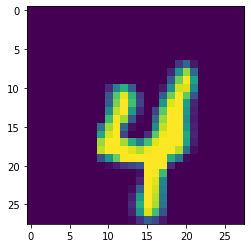

In [11]:
datagen.fit(train_images)
train_generator = datagen.flow(train_images)
batch = train_generator.next()
plt.imshow(batch[0][:, :, 0])

In [24]:
# Build the model.
conv_model = Sequential([
  Conv2D(32, (3, 3), activation='relu'),
  Conv2D(32, (3, 3), activation='relu'),
  MaxPool2D((2, 2)),
  BatchNormalization(),
  Dropout(0.2),

  Conv2D(64, (3, 3), activation='relu'),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPool2D((2, 2)),
  BatchNormalization(),
  Dropout(0.2),

  Flatten(),

  Dense(128, activation='relu'),
  Dense(10, activation='softmax'),
])

# Compile the model.
conv_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [25]:
history_2 = conv_model.fit(datagen.flow((train_images, train_labels), batch_size=8,
         subset='training'),
         validation_data=datagen.flow((train_images, train_labels),
         batch_size=8, subset='validation'),
         epochs=5)

Epoch 1/5
6000/6000 [==============================] - 55s 9ms/step - loss: 0.2067 - accuracy: 0.9361 - val_loss: 0.0887 - val_accuracy: 0.9732
Epoch 2/5
6000/6000 [==============================] - 51s 9ms/step - loss: 0.1001 - accuracy: 0.9715 - val_loss: 0.0842 - val_accuracy: 0.9763
Epoch 3/5
6000/6000 [==============================] - 53s 9ms/step - loss: 0.0779 - accuracy: 0.9775 - val_loss: 0.0676 - val_accuracy: 0.9788
Epoch 4/5
6000/6000 [==============================] - 52s 9ms/step - loss: 0.0659 - accuracy: 0.9807 - val_loss: 0.0598 - val_accuracy: 0.9855
Epoch 5/5
6000/6000 [==============================] - 52s 9ms/step - loss: 0.0621 - accuracy: 0.9819 - val_loss: 0.0448 - val_accuracy: 0.9868


In [22]:
# Evaluate the model.
conv_model.evaluate(test_datagen.flow(test_images, test_labels))

313/313 [==============================] - 2s 5ms/step - loss: 0.0447 - accuracy: 0.9886


[0.04465644806623459, 0.9886000156402588]

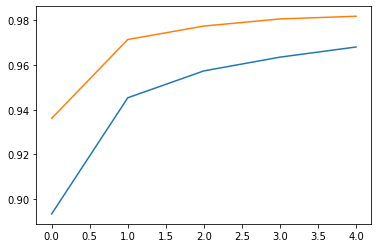

In [37]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_2.history['accuracy'])